# Cell Type Prediction 

This notebook summarizes the efforts to perform cell type prediction on Marioni E65 Mouse Gastrulation data.

See the other notebooks for the various parameterization attempts, as well for obtaining the initial dataset.

### Load the library

This is a library I wrote that is flexible to different model structures, intra-layer rectifiers, and output activation layers.

In [2]:
from pandas import read_csv
import CellTypePredictor as ctp

### Load the training data

This the annotated Marioni data consisting cell annotations such as library size, number of features, and the top 2000 DE genes in the dataset. 

(See: "1_prime_the_data.ipynb" for how this was generated)

In [19]:
raw_dataset = read_csv("celltype_prediction_test.tsv.gz", delimiter="\t")
raw_dataset

,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3,Celltype
0,8010,2391,0,0,0,0,0,2,0,1,...,0,0,2,0,0,0,0,0,0,Epiblast
1,6122,2087,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Epiblast
2,10022,2809,0,0,0,0,0,4,0,4,...,0,0,1,0,0,0,0,0,0,Epiblast
3,8759,2429,0,1,0,0,0,0,0,3,...,0,0,1,0,0,0,0,0,0,Epiblast
4,5718,2014,0,0,0,0,0,3,0,2,...,0,0,1,0,0,0,0,0,0,Epiblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,12273,3221,0,0,0,0,0,4,0,4,...,1,0,3,0,0,0,0,0,0,ExE ectoderm
2071,8347,2549,0,0,0,1,0,15,0,3,...,0,0,2,0,0,0,0,0,0,ExE ectoderm
2072,9364,2734,2,0,0,0,0,5,0,3,...,0,0,2,0,0,0,0,0,0,ExE ectoderm
2073,7918,2302,0,0,1,0,0,0,0,2,...,0,0,3,0,0,0,0,0,0,Anterior Primitive Streak


**Note** the first two colums:
* nCount_RNA, the number of transcripts in a cell
* nFeature_RNA, the number of genes "detected" in a cell

**Note** the remaining columns:
* This is a list of 2000 top differentially expressed genes across the entire dataset as determined by Seurat.

**Note** the last column: "Celltype"
* All the other 2002 columns are input variables to train on
* The 1 celltype output variable we are trying to predict.

In [25]:
raw_dataset["Celltype"].value_counts()

Epiblast                          856
ExE ectoderm                      403
Primitive Streak                  326
ExE endoderm                      197
Nascent mesoderm                  138
Visceral endoderm                 109
Mixed mesoderm                     20
Anterior Primitive Streak          13
PGC                                 3
Surface ectoderm                    3
Haematoendothelial progenitors      3
Rostral neurectoderm                2
Def. endoderm                       2
Name: Celltype, dtype: int64

# Running the Model

## Building the Model

We're going to use a model of 4 layers that scales the input 2002 variables and feeds it into a densely connected 500 node layer, which feeds forward into a 100 node layer, then to 10, and then finally to the one output layer.

By default the predictor uses Sigmoid activation in the final layer, and uses the ReLU rectifier in between linear layers.

We also learned from the "3_automated.ipynb" notebook that a long epoch training period of 2000 cycles, fed in small batches of 10 samples appears to give the best results.

In [5]:
## Define the input output layers
layers = ((2002, 500),    ## input variables → first layer
          (500, 100),     ## prev layer → next layer
          (100, 10),      ## ... 
          (10, 1))        ## prev layer → output variable
predict_var = "Celltype" 
n_epochs = 2000  ## How many times to feed all the data
batch_size = 10  ## What size to chunk the data
seed = 99999     ## Starting seed for deterministic computation

## Perform the training

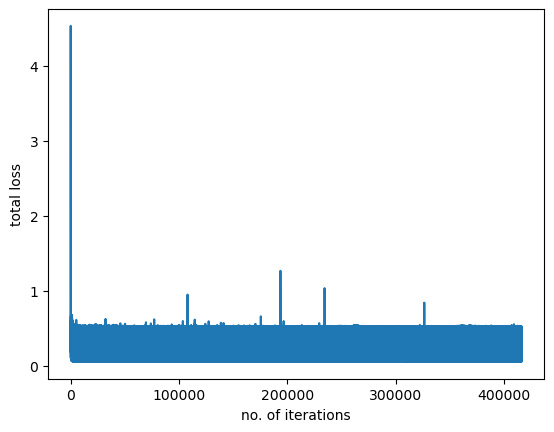

In [6]:
ct_pred = ctp.CellTypePrediction(raw_dataset, predict_var, layers,
                                 n_epochs=n_epochs, batch_size=batch_size,
                                 seed=seed)

The loss can be a lot lower (I've seen ~0.2 at different parameters, but we don't want to overfit).

In [8]:
ct_pred.determineAccuracy()

Mean Accuracy: 0.4125301241874695


Feeding the training back inside gives 41% accuracy, which isn't the worse.

## Perform the testing

#### Generate test data from training

Make test data that makes 2 pseudocells per output class, sampled (with replacement) from 10 cells in that class.

In [10]:
test_dataset = ct_pred.makePseudoCells(nperclass=2, from_n=10)
test_dataset

Created 26 pseudo cells from the averages of cells in the same output group


,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Gpc6,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3
Epiblast,12062.0,2936.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Epiblast,9510.0,2553.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Primitive Streak,10720.0,2724.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Primitive Streak,9803.0,2619.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE endoderm,9293.0,2657.0,58.0,24.0,59.0,38.0,24.0,74.0,0.0,36.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE endoderm,10807.0,2761.0,85.0,30.0,76.0,82.0,33.0,87.0,0.0,39.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Visceral endoderm,8792.0,2568.0,35.0,8.0,29.0,58.0,9.0,52.0,6.0,13.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Visceral endoderm,8323.0,2550.0,23.0,7.0,26.0,35.0,8.0,45.0,10.0,14.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE ectoderm,13335.0,3162.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE ectoderm,14273.0,3295.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,3.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prediction

In [12]:
prediction = ct_pred.doLabelPrediction(test_dataset)

In [15]:
print(f"Accuracy of test predictions {prediction["score_perc"]}%")

Accuracy of test predictions 80%


In [17]:
prediction["result"]

,Pseudo,Predicted
0,Epiblast,Epiblast
0,Epiblast,Epiblast
0,Primitive Streak,Epiblast
0,Primitive Streak,Epiblast
0,ExE endoderm,ExE endoderm
0,ExE endoderm,ExE endoderm
0,Visceral endoderm,ExE endoderm
0,Visceral endoderm,ExE endoderm
0,ExE ectoderm,ExE ectoderm
0,ExE ectoderm,ExE ectoderm


Primitive Streak → Epiblast, and Visceral Endoderm → Exe Endoderm, seem to be the main misattributed classes, but they are close to each other developmentally.